In [20]:
#Function to get isolines from the Here API. 

import requests
import geopandas as gpd
from geopandas import GeoSeries
from shapely.geometry import Polygon
import folium
import citydelconfig as config
import pandas as pd
google_api = "https://maps.googleapis.com/maps/api/geocode/json?address={}+{}&key=" + config.google_api_key

name = "hereapi"
ID = config.here_api_key
CODE = config.here_api_code

head = 'https://isoline.route.cit.api.here.com/routing/7.2/calculateisoline.json?'
URL_Base = '{}app_id={}&app_code={}&mode=fastest;{};traffic:{}&start=geo!{},{}&range={}&rangetype={}'
URL_Base_dep = '{}app_id={}&app_code={}&mode=fastest;{};traffic:{}&departure={}&start=geo!{},{}&range={}&rangetype={}'

def get_isodata(location, type_iso = 'time', range_iso = 3600, travel_mode = 'car', traffic='disabled', departure=None): #receives a single location
    """ Function uses Here API to generate isolines depending on input parameters
    
    Parameters:
    location - Tuple of coordinates (lat, long)
    type_iso - Type of isoline, distance or time based, defaults to time
    range_iso - Range of the isoline depending on type_iso (in seconds), defaults to 1 hour
    travel_mode - Type of transit, can be truck, car or pedestrian
    traffic - toggles enabled or disabled
    departure - Departure time in format YYYY-MM-DDTHH:MM:SS (can include timezone)
    """
    
    if departure == None:
        url = URL_Base.format(head, ID, CODE, travel_mode, traffic, location[0], location[1], range_iso, type_iso) 
    else: 
        url = URL_Base_dep.format(head, ID, CODE, travel_mode, traffic, departure, location[0], location[1], range_iso, type_iso)
    try: 
        js = requests.get(url).json()['response']
        iso = js['isoline']
        coords = Polygon([(float(x.split(',')[1]), float(x.split(',')[0])) for x in iso[0]['component'][0]['shape']])
        geojs = gpd.GeoSeries([coords])
        geojs.crs = {'init' : 'epsg:4326'}
        return geojs
    except KeyError:
        js = requests.get(url).json()
        print(js)
        raise ValueError("HereAPI doesn't have data requested")
    except IndexError:
        print(js)
        raise ValueError("HereAPI doesn't have quality data")
        
            

In [2]:
#Function to plot isoline on a map, needs coordinates to start out

def isoplot(center, locations, outputfile = 'out.html'):
    """ Function creates a plot of the isoline on top of a map
    
    Parameters:
    center - Center for the map to be created (lat, long)
    locations - Geoseries/Geodataframe of isoline/isolines
    outputfile - Output location in .html extension
    """
    
    fm = folium.Map(location = center, zoom_start=8, tiles='CartoDBPositron')
    geojson = locations.__geo_interface__
    geojson['style_function'] = {"__comment": "all SVG styles allowed", "fill":"blue", "stroke-width":"3", "fill-opacity":0.6}
    folium.GeoJson(geojson).add_to(fm)
    fm.save(outputfile)
    print('map saved to %s' %outputfile)

In [3]:
def iso_function(features):
    return {'fillOpacity': 0.1, 'weight': 3, 'fillColor': 'blue'}

def iso_function_shp(features):
    return {'fillOpacity': 0.2, 'weight': 3, 'color' : 'red', 'fillColor': 'red'}

    

def isoplot_shp(center, locations, geo_shp, outputfile = 'out.html'):
    fm = folium.Map(location = center, zoom_start=8, tiles='CartoDBPositron')
    geojson = locations.__geo_interface__
    folium.GeoJson(geojson, style_function = iso_function).add_to(fm)
    geojson = geo_shp.__geo_interface__
    folium.GeoJson(geojson, style_function = iso_function_shp).add_to(fm)
    fm.save(outputfile)
    print('map saved to %s' %outputfile)

In [4]:
#secondary functions for different types of input data to plot
    
def isoplot_contour(center, locations, outputfile):
    #takes a center, and a list of isolines to create a contour map
    fm = folium.Map(location = center, zoom_start = 10, tiles = 'CartoDBPositron')
    for loc in locations:
        geojson = loc.__geo_interface__
        geojson['style'] = {"__comment": "all SVG styles allowed", "fill":"red", "stroke-width":"3", "fill-opacity":0.6}
        folium.GeoJson(geojson).add_to(fm)
    fm.save(outputfile)
    print('map saved to %s' %outputfile)
    
def get_isodata_list(locations, range_iso = 3600, type_iso = 'time', traffic = 'disabled'): 
    #recevies many locations, as a list of tuples of locations
    isoclines = []
    for loc in locations: 
        try:
            line = get_isodata(loc, range_iso, type_iso, traffic)
            isoclines.append(line)
        except ValueError:
            pass
    return isoclines

        
def make_list(centers, names, color, range_iso = 3600, type_iso = 'time', traffic = 'disabled'):
    for i, center in enumerate(centers):
        try:
            line = get_isodata(center, range_iso, type_iso, traffic)    
        except ValueError:
            pass
        isoplot(center, line, 'red', 'isoclines/' + names[i] +'.html')

In [5]:
#Get isolines for a location 

def get_contour_series(center):
    locs_all = []
    for time in range(600, 9000, 600):
        locs_at_time = get_isodata(center, range_iso = time, traffic='enabled', departure='2019-02-13T16:00:00')
        locs_all.append(locs_at_time[0]) 
    locs_geo = GeoSeries([a for a in locs_all])
    locs_geo.crs = {'init': 'epsg:4326'}
    return locs_geo

In [9]:
#examples of using get_isodata and isoplot for different cities and times

abad_center = (23.027496, 72.572697)
locsabad = get_isodata(abad_center, range_iso = 3600, type_iso = 'time')
isoplot(abad_center, locsabad,'abad.html')
locsabad2 = get_isodata(abad_center, traffic='enabled', departure='2019-02-13T17:00:00')
isoplot(abad_center, locsabad2, '../abad_traffic.html')

mumbai_center = (19.060828, 72.872478)
locs = get_isodata(mumbai_center, traffic='enabled', departure='2019-02-13T17:00:00')
isoplot(mumbai_center, locs, 'mumbai_traffic.html')
locs2 = get_isodata(mumbai_center, traffic='disabled', departure = '2019-02-13T23:00:00')
isoplot(mumbai_center, locs2, 'mumbai_notraffic2.html')

google_api = "https://maps.googleapis.com/maps/api/geocode/json?address={}+{}&key=" + config.google_api_key
js = requests.get(google_api.format('Chicago', 'IL')).json()['results'][0]['geometry']
chicago_center = (float(js['location']['lat']), float(js['location']['lng']))
chicago_iso = get_contour_series(chicago_center)
isoplot_shp(chicago_center, chicago_iso, cbsa_data[cbsa_data['NAME'].str.contains('Chicago')], 'chicago_traffic.html')



#hereapi.isoplot(home, locs,'red','out.html')

map saved to abad.html
map saved to ../abad_traffic.html
map saved to mumbai_traffic.html
map saved to mumbai_notraffic2.html


NameError: name 'cbsa_data' is not defined

In [23]:
js = requests.get(google_api.format('Chicago', 'IL')).json()['results'][0]['geometry']
Chicago_center = (float(js['location']['lat']), float(js['location']['lng']))
chicago_series = get_isodata(Chicago_center, range_iso = 90*60)
chicago_cbsa = cbsa_data[cbsa_data['NAME'].str.contains('Chicago')]
chicago_cbsa = chicago_cbsa[chicago_cbsa['NAME'].str.contains('IL')]
chicago_cbsa = chicago_cbsa.to_crs({'init':'epsg:4326'})
urban_areas_local = urban_areas[urban_areas['NAME10'].str.contains('Chicago')]
isoplot_shp(Chicago_center, chicago_series, chicago_cbsa, 'chicago.html')



map saved to chicago.html


In [43]:
urban_areas['']

,UACE10,GEOID10,NAME10,NAMELSAD10,LSAD10,MTFCC10,UATYP10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry
0,24310,24310,"Dixon, IL","Dixon, IL Urban Cluster",76,G3500,C,S,25498865,938057,+41.8529507,-089.4817439,"POLYGON ((-89.498589 41.854668, -89.498538 41...."
1,27847,27847,"Escanaba, MI","Escanaba, MI Urban Cluster",76,G3500,C,S,46643396,283456,+45.7959215,-087.0945936,"(POLYGON ((-87.09518500000001 45.796922, -87.0..."
2,18100,18100,"Clintonville, WI","Clintonville, WI Urban Cluster",76,G3500,C,S,5854683,502563,+44.6232203,-088.7611283,"POLYGON ((-88.78650499999999 44.629957, -88.78..."
3,06166,06166,"Bedford, IN","Bedford, IN Urban Cluster",76,G3500,C,S,30403328,2314,+38.8566530,-086.5012383,"(POLYGON ((-86.52019799999999 38.867827, -86.5..."
4,75270,75270,"Riverdale, CA","Riverdale, CA Urban Cluster",76,G3500,C,S,2306821,0,+36.4310710,-119.8620544,"POLYGON ((-119.869132 36.430832, -119.870931 3..."
5,90946,90946,"Visalia, CA","Visalia, CA Urbanized Area",75,G3500,U,S,164305066,39512,+36.2934877,-119.3006857,"(POLYGON ((-119.144544 36.306106, -119.143445 ..."
6,74044,74044,"Reedley--Dinuba, CA","Reedley--Dinuba, CA Urban Cluster",76,G3500,C,S,29675228,102282,+36.5715321,-119.4234090,"(POLYGON ((-119.469358 36.59337, -119.469378 3..."
7,24445,24445,"Dos Palos, CA","Dos Palos, CA Urban Cluster",76,G3500,C,S,5501806,0,+36.9781625,-120.6337065,"POLYGON ((-120.639719 36.990805, -120.639082 3..."
8,56251,56251,"Merced, CA","Merced, CA Urbanized Area",75,G3500,U,S,122971173,11735,+37.3309547,-120.5257119,"(POLYGON ((-120.499175 37.341557, -120.500581 ..."
9,28657,28657,"Fairfield, CA","Fairfield, CA Urbanized Area",75,G3500,U,S,102311929,334969,+38.2591432,-122.0360609,"(POLYGON ((-121.942775 38.283277, -121.942287 ..."


25087701347.41904
28168177957.63158
3080476610.2125397
74150326625.56313
   index CSAFP CBSAFP  GEOID                                   NAME  \
0    254   408  35620  35620  New York-Newark-Jersey City, NY-NJ-PA   

                                           NAMELSAD LSAD MEMI  MTFCC  \
0  New York-Newark-Jersey City, NY-NJ-PA Metro Area   M1    1  G3110   

         ALAND      AWATER     INTPTLAT      INTPTLON  \
0  21478656376  6689442984  +40.8987884  -073.9031302   

                                            geometry  
0  POLYGON ((-74.889819 40.787729, -74.889707 40....  
map saved to NY.html


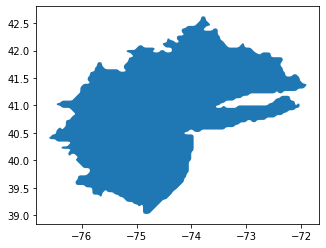

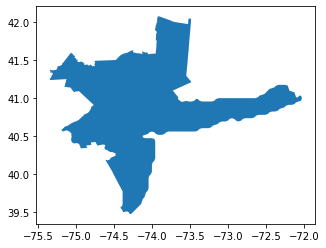

In [78]:
js = requests.get(google_api.format('New York', 'NY')).json()['results'][0]['geometry']
NY_center = (float(js['location']['lat']), float(js['location']['lng']))
chicago_3hr = get_isodata(NY_center, range_iso = 9600)
chicago_3hr.plot()
chicago_cbsa = cbsa_data[cbsa_data['NAME'].str.contains('New York')]
chicago_cbsa = chicago_cbsa.to_crs({'init':'epsg:4326'})
chicago_cbsa = chicago_cbsa.reset_index()
chicago_3hr_intersection = chicago_3hr.intersection(chicago_cbsa)
chicago_difference = chicago_cbsa.difference(chicago_3hr)
chicago_new = chicago_cbsa.difference(chicago_3hr)
chicago_new = chicago_cbsa.difference(chicago_new)
#chicago_new = chicago_new.intersection(chicago_cbsa)
print(geoseries_area(chicago_3hr_intersection))
print(geoseries_area(chicago_cbsa))
print(geoseries_area(chicago_cbsa)-geoseries_area(chicago_3hr_intersection))
print(geoseries_area(chicago_3hr))
print(chicago_cbsa)

isoplot_shp(NY_center, chicago_3hr, chicago_new, 'NY.html')
chicago_new.plot()




In [6]:
#Returns area of a geoseries in square meters
def geoseries_area(geoser):
    area_ser = geoser.to_crs({'proj':'cea'})
    area = area_ser.area
    total_area = 0
    for index, value in area.iteritems():
        total_area += value
    return (total_area / 10**6)

In [7]:
#Reads in US cities shapefiles from cbsa

from geopandas import GeoSeries
us_shp_fp = "tl_2017_us_cbsa/tl_2017_us_cbsa.shp"
cbsa_data = gpd.read_file(us_shp_fp)

#Reads in US_counties shapefiles
US_counties_name = 'UScounties/UScounties.shp'
US_counties = gpd.read_file(US_counties_name)
US_counties.crs = {'init' : 'epsg:4326'} 





In [17]:
cbsa_data[cbsa_data['NAME'].str.contains('Chicago')], 'out.html')

AttributeError: 'NoneType' object has no attribute '__geo_interface__'

In [8]:
#Reads in Oecd Functional urban areas and the function returns the shapefile for a desired
#city by fuaname 

chicago_center = (41.8781136, -87.6297982)
us_shp_fp = "United States/United States.shp"
oecd_data = gpd.read_file(us_shp_fp)


def return_cityshp_oecd(city_name):
    shp =  oecd_data[oecd_data.fuaname == city_name]
    shp = shp.reset_index()
    geoshp = shp.geometry
    geoshp.crs = {'init' :'epsg:4326'}
    return geoshp
        

chicago_shp = return_cityshp_oecd('Chicago')

In [9]:
#Returns the marginal percentage areas that each isoline covers a city shapefile until the
#isoline completely engulfs the city shapefile. Each iteration increases isoline by 10 minutes. 

def cumulative_areas(center, oecd_shape):
    used_shape = oecd_shape.copy()
    oecd_area = geoseries_area(oecd_shape)
    overlap = 10000
    time = 600
    data_list = []
    locs_all = []
    cumu_area = overlap/oecd_area 
    while (cumu_area > 0):
        isoline = get_isodata(center, range_iso = time, traffic = 'enabled', departure = '2019-02-13T16:00:00')
        overlap = geoseries_area(isoline.intersection(used_shape))
        cumu_area = overlap/oecd_area
        data_list.append((time/60, cumu_area))
        used_shape = used_shape.difference(isoline)
        time += 600
    return data_list

In [10]:
#Plots data produced by cumulative_areas function
import numpy as np
import matplotlib.pyplot as plt

def plot_cumu_data(data):
    plt.plot([i[0] for i in data], np.cumsum([i[2] for i in data]), c='blue')
    


In [11]:
#Returns the intersection of the biggest isoline produced by the cumulative_areas function

def intersection_union(center, cum_areas, oecd_shape):
    time,v = cum_areas[-1]
    time = int(time) * 60
    isoline = get_isodata(center, time, traffic = 'enabled', departure = '2019-02-13T16:00:00')
    intersection = geoseries_area(isoline.intersection(oecd_shape))
    union = geoseries_area(isoline.union(oecd_shape))
    return intersection/union



In [12]:
#Returns cumulative_areas data and intersection over union data for a selection of metros
#area larger than 15037776415

def metros_cumu_areas(cbsa_data): 
    is_metro = cbsa_data['LSAD'] == 'M1'
    metros = cbsa_data[is_metro]
    is_big = metros['ALAND'] > 15037776415
    big_metros = metros[is_big]
    metros = big_metros.reset_index()
    CBSAFP = []
    names = []
    coords = []
    shapefiles = []
    cumu_areas = []
    iou_biggest = []
    for i, row in metros.iterrows():
        names.append(row['NAME'])
        CBSAFP.append(row['CBSAFP'])
        coords.append((float(row['INTPTLAT']), float(row['INTPTLON'])))
        geoshp = GeoSeries(row['geometry'])
        geoshp.crs = {'init' :'epsg:4326'}
        shapefiles.append(geoshp)
        try:
            cumu_area = cumulative_areas(coords[i], shapefiles[i])
            cumu_areas.append(cumu_area)
            iou_biggest.append(intersection_union(coords[i], cumu_area, shapefiles[i]))
        except ValueError:
            cumu_area = [(0,0)]
            cumu_areas.append(cumu_area)
            iou_biggest.append(0.0)
    return (cumu_areas, iou_biggest)

In [13]:
#Returns a data frame of data produced by function metros_cumu_areas and produces csv files

def cumu_areas_to_df(cumu_areas, iou_biggest):
    IOU_d = {'CBSAFP': CBSAFP, 'Names' : names, 'IOU' : iou_biggest}
    IOU_data = pd.DataFrame(data=IOU_d)
    CBSAFP_cumu = []
    names_cumu = []
    cumu_times_opened = []
    cumu_percents_opened = []
    for i, table in enumerate(cumu_areas):
        for time, percent in table:
            CBSAFP_cumu.append(CBSAFP[i])
            names_cumu.append(names[i])
            cumu_times_opened.append(time)
            cumu_percents_opened.append(percent)
    CA_d = {'CBSAFP' : CBSAFP_cumu, 'Names' : names_cumu, 
            'Isoline Time Buckets' : cumu_times_opened, 
            'Percentages' : cumu_percents_opened}
    CA_data = pd.DataFrame(data = CA_d)
    CA_data.to_csv('CA_data.csv')
    IOU_data.to_csv('IOU_data.csv')
    return IOU_data, CA_data

In [14]:
#Returns marginal population data from a merged data frame

pop_code = 'B01003_001E'

import censusdata
from census import Census

def marginal_population(merged_data):
    c = Census(census_API_key)
    data = []
    for a in range(16): #getvalue somehowelse
        data.append(0)
    state_data = []
    for state in merged_data.STATEFP.unique():
        state_data.extend(c.acs5.state_county_tract(pop_code, state, Census.ALL, Census.ALL))
    for index, d in enumerate(state_data):
        q = merged_data[(merged_data.STATEFP == d['state']) & 
                        (merged_data.COUNTYFP == d['county']) & 
                        (merged_data.TRACTCE == d['tract'])]
        print(q)
        if q.empty:
            continue
        else:
            try:
                data[q.index_right.item()] += d[pop_code]
            except KeyError:
                data[q.index_right.item()] = d[pop_code]
    return data

In [15]:
#Function returns a data frame consisting of the marginal population and areas of each
#isoline increasing in 10 minutes. The function is given co-ordinates of the center of cities
#and runs until it reaches 98% percentage of the city. 

import censusdata
from census import Census

bg_name = 'BG/tl_2018_{}_bg/tl_2018_{}_bg.shp'
pop_code = 'B01003_001E'
c = Census(config.census_api_key)

def isoline_pops(center, city_shape):
    used_shape = city_shape.copy()
    city_area = geoseries_area(city_shape)
    count = 0
    zero_count = 0
    overlap = 10000
    time = 600
    times = []
    marginal_pops = []
    containments = []
    cumu_pops = []
    cumu_area = overlap/city_area 
    cumu_areas = []
    IOU_list = []
    areas = []
    geometries = []
    merged = gpd.GeoDataFrame()
    states = []
    state_data = []
    states_read = dict()
    st_county_read = dict()
    while (sum(cumu_areas) < 0.98 and count<24 and zero_count < 3): 
        isoline = get_isodata(center, range_iso = time, traffic = 'enabled', departure = '2019-02-13T16:00:00')
        intersection = geoseries_area(isoline.intersection(city_shape))
        isoplot_shp(center, isoline, city_shape, 'isoplots/' + str(count)+'.html')
        print(intersection/(geoseries_area(isoline)))
        containment = (intersection/city_area) * intersection/(geoseries_area(isoline))
        containments.append(containment)
        union = geoseries_area(isoline.union(city_shape))
        IOU_list.append(intersection/union)
        if count == 0:
            isoline_gdf = gpd.GeoDataFrame(geometry = isoline)
            isoline_gdf.crs = {'init':'epsg:4326'}
        else:
            isoline_gdf = gpd.GeoDataFrame(geometry = isoline.difference(prev_isoline))
            isoline_gdf.crs = {'init':'epsg:4326'}
        states = gpd.sjoin(US_counties, isoline_gdf, op="intersects").STATE_FIPS.unique()
        for state in states:
            if state in states_read.keys():
                pass
            else:
                bg_new = gpd.read_file(bg_name.format(state,state))
                bg_new.crs = ({'init':'epsg:4326'})
                states_read[state] = bg_new
                merged = pd.concat([merged, bg_new])
        marginal_pops.append(0)
        current_iso = gpd.sjoin(merged, isoline_gdf, op='intersects')
        for index, row in current_iso.iterrows():
            state_county = row['STATEFP'] + row['COUNTYFP']
            if not (state_county) in st_county_read.keys():
                st_county_read[state_county] = dict()
                county_bg_data = c.acs5.state_county_blockgroup(pop_code, row['STATEFP'], row['COUNTYFP'], Census.ALL)
                for d in county_bg_data:
                    st_county_read[state_county][state_county + d['tract'] + d['block group']] = d[pop_code]
            marginal_pops[count] += st_county_read[state_county][row['GEOID']]
            isoline = isoline.union(row['geometry'])
        overlap = geoseries_area(isoline.intersection(used_shape))
        geometries.append(isoline[0])
        times.append(time/60)
        areas.append(geoseries_area(isoline))
        cumu_area = overlap/city_area
        if cumu_area == 0:
            zero_count += 1
        cumu_areas.append(cumu_area)
        used_shape = used_shape.difference(isoline)
        if count == 0:
            prev_isoline = gpd.GeoDataFrame(geometry = isoline)
            prev_isoline.crs = {'init' : 'epsg:4326'}
        else :
            prev_isoline = gpd.GeoDataFrame(geometry = prev_isoline.union(isoline))
            prev_isoline.crs = {'init' : 'epsg:4326'}
        time += 600
        count += 1
        print(count, containment)
    optima = []
    largest_IOU = []
    cumu_pop = 0
    for index, num in enumerate(marginal_pops):
        try:
            if num > marginal_pops[index+1] and num > marginal_pops[index-1]:
                optima.append(1)
            else:
                optima.append(0)
        except IndexError:
            optima.append(0)
        cumu_pop += num
        cumu_pops.append(cumu_pop)
        if max(IOU_list) == IOU_list[index]:
            largest_IOU.append(1)
        else:
            largest_IOU.append(0)
    return_dict = {'Times' : times, 
                   'Cumulative_Areas' : cumu_areas, 
                   'Areas' : areas,
                   'Marginal_Population' : marginal_pops,
                   'Cumulative_Population' : cumu_pops,
                  'Optima' : optima,
                  'IoU' : IOU_list,
                  'IOU_Largest': largest_IOU}
    return_frame = pd.DataFrame(data = return_dict)
    return return_frame
                

In [66]:
#HERE
urban_areas_name = 'tl_2018_us_uac10/tl_2018_us_uac10.shp'
urban_areas = gpd.read_file(urban_areas_name)
urban_areas.crs = {'init':'epsg:4326'}
isoline_contains(chicago_center, urban_areas)

1200
1800
2400
3000
3600
4200
4800
5400
6000
6600
7200
7800
8400
9000


,Times,Fitness,Isoline_Area,Intersection,Only_Isoline,Greatest Fitness
0,10.0,0.989821,21.982296,21.758531,0.223766,1
1,20.0,0.980730,114.887890,112.673997,2.213893,0
2,30.0,0.973840,267.532928,260.534250,6.998677,0
3,40.0,0.979349,504.947567,494.519899,10.427668,0
4,50.0,0.976570,1048.810012,1024.236706,24.573306,0
5,60.0,0.951736,2234.542732,2126.694342,107.848390,0
6,70.0,0.907084,3867.707245,3508.333714,359.373532,0
7,80.0,0.772342,6207.497979,4794.310401,1413.187578,0
8,90.0,0.602993,10227.600895,6167.169884,4060.431011,0
9,100.0,0.469516,14964.007844,7025.837025,7938.170819,0


In [16]:
def isoline_contains(center, city_shape):
    time = 600
    times = []
    fitness = []
    areas_both = []
    areas_only_isoline = []
    isoline_areas = []
    while(time<9000):
        isoline = get_isodata(center, range_iso = time, traffic = 'enabled', departure = '2019-02-12T16:00:00')
        isoline_gdf = gpd.GeoDataFrame(geometry = isoline)
        intersection = gpd.overlay(isoline_gdf, city_shape, how = 'intersection')
        intersection_area = geoseries_area(intersection)
        isoline_area = geoseries_area(isoline)
        areas_only_isoline.append(isoline_area-intersection_area)
        fitness.append(intersection_area/isoline_area)
        isoline_areas.append(isoline_area)
        areas_both.append(intersection_area)
        times.append(time/60)
        time += 600
        print(time)
    largest_IOU = []
    for index, num in enumerate(fitness):
        if max(fitness) == fitness[index]:
            largest_IOU.append(1)
        else:
            largest_IOU.append(0)
    return_dict = {'Times' : times, 
                   'Fitness' : fitness, 
                   'Isoline_Area' : isoline_areas,
                   'Intersection' : areas_both,
                    'Only_Isoline' : areas_only_isoline,
                  'Greatest Fitness': largest_IOU}
    return_frame = pd.DataFrame(data = return_dict)
    return return_frame
    
    

In [17]:
import re
with open('top_cities.txt', 'r') as f:
        cities = f.readlines()

def top_30_contain_data(cities, cbsa_data):
    car_data_30 = pd.DataFrame()
    for row in cities:
        metro = row.split(',')
        city = metro[1]
        state = metro[2]
        is_metro = cbsa_data['LSAD'] == 'M1'
        metro_data = cbsa_data[is_metro]
        metro_data = metro_data[metro_data['NAME'].str.contains(city)]
        if len(metro_data) != 1:
            shp = metro_data[metro_data['NAME'].str.contains(state)]
        else:
            shp = metro_data[metro_data['NAME'].str.contains(city)]
        shp = shp.reset_index()
        geoshp = GeoSeries(shp['geometry'])
        geoshp.crs = {'init' : 'epsg:4326'}
        city = re.sub(r'\s+', '+', city)
        city = city.replace('.', '')
        url = google_api.format(city, state)
        js = requests.get(url).json()['results'][0]['geometry']
        lat = js['location']['lat']
        long = js['location']['lng']
        coords = (float(lat), float(long))
        print(city, state)
        print(coords)
        #try:
        pop_data = isoline_contains(coords, geoshp)
        cbs_list = []
        name_list = []
        for a in range(0, len(pop_data)):
            cbs_list.append(shp['CBSAFP'][0])
            name_list.append(shp['NAME'][0])
        pop_data.insert(loc = 0, column = 'CBSAFP', value=cbs_list)
        pop_data.insert(loc = 1, column = 'NAME', value=name_list)
        car_data_30 = pd.concat([car_data_30, pop_data], sort=False)
        car_data_30.to_csv('contain_data_30_4pm.csv')
    


In [18]:
with open('top_cities.txt', 'r') as f:
        cities = f.readlines()
urban_areas_name = 'tl_2018_us_uac10/tl_2018_us_uac10.shp'
urban_areas = gpd.read_file(urban_areas_name)
urban_areas = urban_areas.to_crs({'init':'epsg:4326'})
#top_30_contain_data(cities, urban_areas)

In [73]:
import re


def top_30_contain_data(cities, urban_areas):
    car_data_30 = pd.DataFrame()
    for row in cities:
        metro = row.split(',')
        city = metro[1]
        state = metro[2]
        city = re.sub(r'\s+', '+', city)
        city = city.replace('.', '')
        url = google_api.format(city, state)
        js = requests.get(url).json()['results'][0]['geometry']
        lat = js['location']['lat']
        long = js['location']['lng']
        coords = (float(lat), float(long))
        print(city, state)
        print(coords)
        #try:
        pop_data = isoline_contains(coords, urban_areas)
        cbs_list = []
        name_list = []
        for a in range(0, len(pop_data)):
            name_list.append(city)
        pop_data.insert(loc = 1, column = 'NAME', value=name_list)
        car_data_30 = pd.concat([car_data_30, pop_data], sort=False)
        car_data_30.to_csv('contain_urban_data_30_4pm_2.csv')
    

In [52]:
js = requests.get(google_api.format('Boston', 'MA')).json()['results'][0]['geometry']
Boston_center = (float(js['location']['lat']), float(js['location']['lng']))
print(Boston_center)
boston_cbsa = cbsa_data[cbsa_data['NAME'].str.contains('Boston')]
boston_cbsa = boston_cbsa.to_crs({'init':'epsg:4326'})
boston_cbsa = boston_cbsa.reset_index()
isoline_contains(Boston_center, boston_cbsa)

(42.3600825, -71.0588801)


NameError: name 'cbsa_data' is not defined

In [12]:
#Takes in list of cities with index, city name, state abbreviation as well as CBSA shapefiles
#and returns a dataframe of each cities with their marginal populations, cumulative areas, 
#local optima 

import re
google_api = "https://maps.googleapis.com/maps/api/geocode/json?address={}+{}&key=" + config.google_api_key
with open('top_cities.txt', 'r') as f:
        cities = f.readlines()

def top_30_pop_data(cities, cbsa_data):
    car_data_30 = pd.DataFrame()
    for row in cities[1:5]:
        metro = row.split(',')
        city = metro[1]
        state = metro[2]
        is_metro = cbsa_data['LSAD'] == 'M1'
        metro_data = cbsa_data[is_metro]
        metro_data = metro_data[metro_data['NAME'].str.contains(city)]
        if len(metro_data) != 1:
            shp = metro_data[metro_data['NAME'].str.contains(state)]
        else:
            shp = metro_data[metro_data['NAME'].str.contains(city)]
        shp = shp.reset_index()
        geoshp = GeoSeries(shp['geometry'])
        geoshp.crs = {'init' : 'epsg:4326'}
        city = re.sub(r'\s+', '+', city)
        city = city.replace('.', '')
        url = google_api.format(city, state)
        js = requests.get(url).json()['results'][0]['geometry']
        lat = js['location']['lat']
        long = js['location']['lng']
        coords = (float(lat), float(long))
        print(city, state)
        print(coords)
        #try:
        pop_data = isoline_pops(coords, geoshp)
        cbs_list = []
        name_list = []
        for a in range(0, len(pop_data)):
            cbs_list.append(shp['CBSAFP'][0])
            name_list.append(shp['NAME'][0])
        pop_data.insert(loc = 0, column = 'CBSAFP', value=cbs_list)
        pop_data.insert(loc = 1, column = 'NAME', value=name_list)
        car_data_30 = pd.concat([car_data_30, pop_data], sort=False)
        car_data_30.to_csv('car_contain_30_4pm.csv')
        #except (KeyboardInterrupt, SystemExit) as r:
            #raise
        #except Exception as e:
            #print('error', e)
            #pass

 

In [178]:
top_30_contain_data(cities, cbsa_data)

New+York NY
(40.7127753, -74.0059728)
1200
1800
2400
3000
3600
4200
4800
5400
6000
6600
7200
7800
8400
9000
9600
10200
10800
Los+Angeles CA
(34.0522342, -118.2436849)
1200
1800
2400
3000
3600
4200
4800
5400
6000
6600
7200
7800
8400
9000
9600
10200
Chicago IL
(41.8781136, -87.6297982)
1200
1800
2400
3000
3600
4200
4800
5400
6000
6600
7200
7800
8400
9000
Houston TX
(29.7604267, -95.3698028)
1200
1800
2400
3000
3600
4200
4800
5400
6000
6600
7200
7800
8400
9000
9600
10200
10800
Philadelphia PA
(39.9525839, -75.1652215)
1200
1800
2400
3000
3600
4200
4800
5400
6000
6600
7200
7800
8400
9000
9600
10200
Phoenix AZ
(33.4483771, -112.0740373)
1200
1800
2400
3000
3600
4200
4800
5400
6000
6600
7200
7800
8400
9000
9600
10200
10800
San+Antonio TX
(29.4241219, -98.49362819999999)
1200
1800
2400
3000
3600
4200
4800
5400
6000
6600
7200
7800
8400
San+Diego CA
(32.715738, -117.1610838)
1200
1800
2400
3000
3600
4200
4800
5400
6000
6600
7200
7800
8400
9000
9600
10200
10800
Dallas TX
(32.7766642, -96.7969878

In [46]:
AUE_Ahmedabad_name = 'Ahmedabad/urban_edge_t3.shp'
AUE_Ahmedabad = gpd.read_file(AUE_Ahmedabad_name)
AUE_Ahmedabad = AUE_Ahmedabad.to_crs({'init' : 'epsg:4326'})
js = requests.get(google_api.format('Ahmedabad', '')).json()['results'][0]['geometry']
abad_center = (float(js['location']['lat']), float(js['location']['lng']))
isoplot(abad_center, AUE_Ahmedabad, 'ahmedabad_urbant3.html')
#AUE_Ahmedabad.plot()

map saved to ahmedabad_urbant3.html


In [16]:
import rasterio
dataset = rasterio.open('esp_ppp_2018.tif')

google_api = "https://maps.googleapis.com/maps/api/geocode/json?address={}+{}&key=" + config.google_api_key
js = requests.get(google_api.format('Barcelona', 'Spain')).json()['results'][0]['geometry']
barca_center = (float(js['location']['lat']), float(js['location']['lng']))
barca_iso_30 = get_isodata(barca_center, range_iso = 1800, traffic='enabled', departure='2019-02-13T17:00:00')
barca_iso_1hr = get_isodata(barca_center, range_iso = 3600)
barca_gdf_30 = gpd.GeoDataFrame(geometry = barca_iso_30)
barca_gdf_30.crs = {'init':'epsg:4326'}
barca_gdf_1hr = gpd.GeoDataFrame(geometry = barca_iso_1hr)
barca_gdf_1hr.crs = {'init':'epsg:4326'}



In [58]:
from rasterstats import zonal_stats
stats = zonal_stats(barca_iso_30, 'esp_ppp_2018.tif', stats=['min', 'max', 'median', 'majority', 'sum', 'count'])

In [91]:
stats_2 = zonal_stats(barca_iso_1hr, 'esp_ppp_2018.tif', stats=['min', 'max', 'median', 'majority', 'sum', 'count'])

In [41]:
from rasterstats import zonal_stats
def isoline_raster_pops(center, city_shp):
    count = 0
    times = []
    marginal_pops = []
    cumu_pops = []
    marginal_areas = []
    cumulative_areas = []
    for time in range(600, 7800, 600):
        isoline = get_isodata(center, range_iso = time, traffic = 'enabled', departure = '2019-02-13T18:00:00')
        if count == 0:
            isoline_gdf = gpd.GeoDataFrame(geometry = isoline)
            isoline.crs = {'init':'epsg:4326'}
        else:
            isoline_gdf = gpd.GeoDataFrame(geometry = isoline.difference(prev_isoline))
            isoline_gdf.crs = {'init':'epsg:4326'}
        iso_stats = zonal_stats(isoline_gdf, city_shp, stats= ['count', 'sum'])
        print(iso_stats)
        iso_pop = iso_stats[0]['sum']
        marginal_pops.append(int(iso_pop))
        area = geoseries_area(isoline)
        marginal_areas.append(area)
        if count == 0:
            prev_isoline = gpd.GeoDataFrame(geometry = isoline)
            prev_isoline.crs = {'init' : 'epsg:4326'}
        else :
            prev_isoline = gpd.GeoDataFrame(geometry = prev_isoline.union(isoline))
            prev_isoline.crs = {'init' : 'epsg:4326'}
        times.append(time/60)
        count += 1
        print(count)
    optima = []
    cumu_pop = 0
    cumu_area = 0
    for index, num in enumerate(marginal_pops):
        try:
            if num > marginal_pops[index+1] and num > marginal_pops[index-1]:
                optima.append(1)
            else:
                optima.append(0)
        except IndexError:
            optima.append(0)
        cumu_pop += num
        cumu_pops.append(cumu_pop)
        cumu_area += marginal_areas[index]
        cumulative_areas.append(cumu_area)
    return_dict = {'Times' : times, 
                   'Marginal_Areas' : marginal_areas, 
                   'Cumulative_Areas' :cumulative_areas,
                   'Marginal_Population' : marginal_pops,
                   'Cumulative_Population' : cumu_pops,
                   'Maxima' : optima}
    return_frame = pd.DataFrame(data = return_dict)
    return return_frame
    
            
    

In [42]:
isoline_raster_pops(barca_center, 'esp_ppp_2018.tif')

[{'count': 1906, 'sum': 273811.96875}]
1
[{'count': 12794, 'sum': 1558781.875}]
2
[{'count': 42763, 'sum': 1599583.0}]
3
[{'count': 102378, 'sum': 1271230.5}]
4
[{'count': 129058, 'sum': 628577.625}]
5
[{'count': 186008, 'sum': 585263.1875}]
6
[{'count': 285136, 'sum': 329112.8125}]
7
[{'count': 415921, 'sum': 734838.625}]
8
[{'count': 437419, 'sum': 389679.625}]
9
[{'count': 591756, 'sum': 288269.21875}]
10
[{'count': 513917, 'sum': 240142.6875}]
11
[{'count': 487647, 'sum': 330923.0625}]
12


,Times,Marginal_Areas,Cumulative_Areas,Marginal_Population,Cumulative_Population,Maxima
0,10.0,12.401876,12.401876,273811,273811,0
1,20.0,97.943886,110.345762,1558781,1832592,0
2,30.0,383.330050,493.675812,1599583,3432175,1
3,40.0,1069.148017,1562.823829,1271230,4703405,0
4,50.0,1915.986837,3478.810666,628577,5331982,0
5,60.0,3130.273688,6609.084354,585263,5917245,0
6,70.0,5042.957215,11652.041569,329112,6246357,0
7,80.0,7731.171471,19383.213039,734838,6981195,1
8,90.0,10590.890010,29974.103050,389679,7370874,0
9,100.0,14601.730497,44575.833547,288269,7659143,0


In [43]:
list_cities_spain = ['Madrid', 'Barcelona', 'Valencia', 'Seville', 'Bilbao']
google_api = "https://maps.googleapis.com/maps/api/geocode/json?address={}+{}&key=" + config.google_api_key
spain_raster = 'esp_ppp_2018.tif'

def top_raster(list_cities, raster_filename):
    city_pop_data = pd.DataFrame()
    for city in list_cities:
        print(city)
        js = requests.get(google_api.format(city, 'Spain')).json()['results'][0]['geometry']
        city_center = (float(js['location']['lat']), float(js['location']['lng']))
        pop_data = isoline_raster_pops(city_center, raster_filename)
        name_list = []
        for a in range(0, len(pop_data)):
            name_list.append(city)
        pop_data.insert(loc = 1, column = 'NAME', value=name_list)
        city_pop_data = pd.concat([city_pop_data, pop_data], sort=False)
        city_pop_data.to_csv('spain_data.csv')


In [44]:
top_raster(list_cities_spain, spain_raster)

Madrid
[{'count': 2801, 'sum': 316433.5625}]
1
[{'count': 46651, 'sum': 2949619.25}]
2
[{'count': 126267, 'sum': 2342222.5}]
3
[{'count': 228054, 'sum': 1144726.75}]
4
[{'count': 440826, 'sum': 653679.75}]
5
[{'count': 476715, 'sum': 357776.875}]
6
[{'count': 781053, 'sum': 275519.84375}]
7
[{'count': 902180, 'sum': 210947.71875}]
8
[{'count': 1026408, 'sum': 264976.78125}]
9
[{'count': 1323348, 'sum': 151895.734375}]
10
[{'count': 1493694, 'sum': 285655.03125}]
11
[{'count': 2218958, 'sum': 230410.1875}]
12
Barcelona
[{'count': 1906, 'sum': 273811.96875}]
1
[{'count': 12794, 'sum': 1558781.875}]
2
[{'count': 42763, 'sum': 1599583.0}]
3
[{'count': 102378, 'sum': 1271230.5}]
4
[{'count': 129058, 'sum': 628577.625}]
5
[{'count': 186008, 'sum': 585263.1875}]
6
[{'count': 285136, 'sum': 329112.8125}]
7
[{'count': 415921, 'sum': 734838.625}]
8
[{'count': 437419, 'sum': 389679.625}]
9
[{'count': 591756, 'sum': 288269.21875}]
10
[{'count': 513917, 'sum': 240142.6875}]
11
[{'count': 487647, 's

In [5]:
urban_areas_name = 'tl_2018_us_uac10/tl_2018_us_uac10.shp'
urban_areas = gpd.read_file(urban_areas_name)
urban_areas.crs

{'init': 'epsg:4269'}

In [1]:
la_iso = get_isodata(LA_center)
la_iso_gdf = gpd.GeoDataFrame(geometry = la_iso)
california = urban_areas[urban_areas['NAME10'].str.contains('CA')]
california = california.to_crs({'init':'epsg:4326'})
print(type(california))
la_inter = gpd.overlay(la_iso_gdf, urban_areas, how='intersection')
print(geoseries_area(la_inter))
isoplot(LA_center, la_inter, 'la2.html')

NameError: name 'get_isodata' is not defined

{'init': 'epsg:4326'}

CRS.from_epsg(4326)